Comment on actual work: 

The notebook started being based on this tutorial: https://colab.research.google.com/github/rbkhb/NLP_IMC/blob/master/BERT_Fine_Tuning_Sentence_Classification.ipynb#scrollTo=fwQ7JcuJQZ0o

But right now the path that seems more logical is https://medium.com/analytics-vidhya/multi-label-text-classification-using-transformers-bert-93460838e62b 

Still, after the "Encode Labels" part, everything is based on the first reference


# **Packages**

In [57]:
!pip install -U sentence-transformers
!pip install transformers
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
% matplotlib inline
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# **Dataframe**

In [36]:
df = pd.read_csv("/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/twsm_project_corpus0.csv")
df.head(5)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined
df.head(10)

,Unnamed: 0,text,accept,labels_str
0,0,The other part of our data consists of an undi...,[Data],Data
1,1,This list of actors can be interpreted to repr...,[Definition],Definition
2,2,The two samples were compared on all study var...,"[Method, Theory]",Method Theory
3,3,This is supported by a more recent report by ...,[RelationToLiterature],RelationToLiterature
4,4,", the false noise parameter C was misstated by...",[Definition],Definition
5,5,"In the strategic management literature, the na...",[RelationToLiterature],RelationToLiterature
6,6,"No such link was found however, but, according...",[FutureWork],FutureWork
7,7,The problem is that the timeliness of the data...,"[Data, Limitation]",Data Limitation
8,8,The social sciences differ from the physical s...,[RelationToLiterature],RelationToLiterature
9,9,Browne et al. START_CITE [3] END_CITE CITE_b...,[RelationToLiterature],RelationToLiterature


## **Should we apply this pre_process? (Doesnt work yet, tho)**

In [47]:
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [53]:
#fail
pre_process(df["text"])

ValueError: ignored

## **Max_len decision**

Text(0, 0.5, 'Word count')

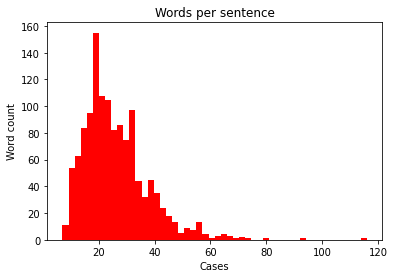

In [34]:
#Count words per sentence so we can set an appropiate max_len. In this case, 150 will be more than enough.
word_list = [len(x.split()) for x in df["text"].tolist()]
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(word_list, bins=50, histtype='bar')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('r')

plt.title("Words per sentence")
plt.xlabel('Cases')
plt.ylabel('Word count')


In [ ]:
# Set the maximum sequence length.
MAX_LEN = 150

# **Encode labels**

In [10]:
############# LabelEncoder (1st try)
#le = preprocessing.LabelEncoder()
#le.fit(df["labels_str"])

#le.classes_

#df["labels_encoded"]=le.fit_transform(df["labels_str"])

#le.inverse_transform([0, 0, 1, 2])

In [ ]:
#df.head().sort_values("labels_encoded", ascending=True)

In [41]:
#Medium tutorial (https://medium.com/analytics-vidhya/multi-label-text-classification-using-transformers-bert-93460838e62b)

mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(df["accept"])
# Getting a sense of how the tags data looks like
print(accept_MLB[0])
print(mlb.inverse_transform(accept_MLB[0].reshape(1,-1)))
print(mlb.classes_)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[('Data',)]
['Contribution' 'Data' 'Definition' 'EmpiricalResult' 'FutureWork' 'Goal'
 'Hypothesis' 'HypothesisResult' 'Item' 'Limitation' 'Method' 'Motivation'
 'RelationToLiterature' 'ResearchQuestion' 'Theory']


# **Tokenize**

In [62]:
#Medium tutorial

inputs = self.tokenizer.encode_plus(
            df["text"],
            None,
            add_special_tokens=True,#Add [CLS] [SEP] tokens
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False, 
            return_attention_mask= True,#diff normal/pad tokens
            truncation= True,# Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )

NameError: ignored

## **From here on, everything is from the first reference https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=e5vZhQpvkE8s**

In [16]:
# Create sentence and label lists
#sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
#sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
#labels = df.accept_MLB

In [13]:
num_labels = df.labels_encoded.nunique()
print(num_labels)
#df.labels_encoded.value_counts()

153


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2844223.12B/s]


Tokenize the first sentence:
['[CLS]', 'the', 'other', 'part', 'of', 'our', 'data', 'consists', 'of', 'an', 'und', '##ire', '##cted', 'social', 'graph', '.', '[SEP]']


In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.05)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.05)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [14]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", problem_type="multi_label_classification", num_labels=num_labels, id2label=id2label, label2id=label2id) #number of unique values in labels, probably should be reduced
model.cuda()

  6%|▌         | 23532544/407873900 [00:03<00:35, 10857044.23B/s]

KeyboardInterrupt: ignored

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# Hyperparameters for training loop
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   13618 MB |   13620 MB |   26772 MB |   13154 MB |\n|       from large pool |   13616 MB |   13618 MB |   26768 MB |   13152 MB |\n|       from small pool |       2 MB |       2 MB |       4 MB |       2 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   13618 MB |   13620 MB |   26772 MB |   13154 MB |\n|       from large pool |   13616 MB |   13618 MB |

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()